## Imports

In [6]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2 as cv
from torch.optim.lr_scheduler import _LRScheduler

from models.vae import VAE
from models.rvae import RVAE
from models.dvae import DVAE
from models.base import Decoder, Encoder

from IPython.display import clear_output

print('imported')

imported


## Constants

In [7]:
np.random.seed(42)

DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

WEIGHTS_DIR = './weights'
if not os.path.exists(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01
LATENT_DIM = 64
IN_CHANNELS = 1
NUM_CHANNELS = 256
ENC = '128x1,128d2,64x1,64d2,32x1,32d2,16x1,16d2,8x1,8d2,4x1'
# ENC = '32d2,16d2,8d2,4x1'
DEC = '4x1,4u2,8x1,8u2,16x1,16u2,32x1,32u2,64x1,64u2,128x1'
# DEC = '4x1,4u2,8u2,16u2'
BOTTLENECK_RATIO = 0.25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device: {} ({})'.format(device, torch.cuda.get_device_name(device)))

Current device: cuda (NVIDIA RTX A6000)


## Data preprocessing

#### MNIST

In [4]:
# dans un premier lieu, nous allons travailler avec MNIST
mnist = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True)

n_samples = 60

# removing some digits to reduce the size of the dataset
selected_index = np.isin(mnist.targets, [9])
images = mnist.data[selected_index][:n_samples]
targets = mnist.targets[selected_index][:n_samples]

# preprocessing
images = images.reshape(-1, 1, 28, 28)
images = T.functional.resize(images, IMG_SIZE)
images = images.__div__(255).type(torch.float32)

train_x, test_x, train_y, test_y = train_test_split(images, targets, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(train_x, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=BATCH_SIZE, shuffle=False)

print('Number of training samples: {}'.format(len(train_x)))
print('Number of test samples: {}'.format(len(test_x)))
print('Number of iterations per epoch: {}'.format(len(train_loader)))
print('Image size: {}'.format(train_x.shape))

Number of training samples: 54
Number of test samples: 6
Number of iterations per epoch: 1
Image size: torch.Size([54, 1, 32, 32])


#### BraTS

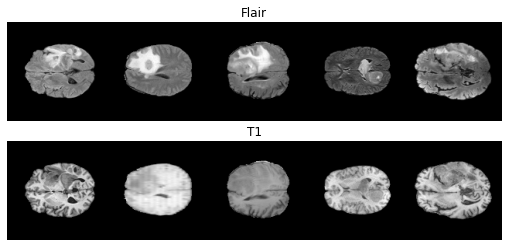

Number of samples: 500
Image size: torch.Size([128, 128])
Total shape: torch.Size([500, 1, 128, 128])


In [11]:
# loading brats dataset
data = np.load('./data/brats_data.npz')
flair, t1 = data['flair'][:500], data['t1'][:500]


# preprocessing
n_max_flair = [flair[i].max() for i in range(flair.shape[0])]
n_max_t1 = [t1[i].max() for i in range(t1.shape[0])]

for idx in range(0, flair.shape[0]):
    flair[idx] = (flair[idx] / n_max_flair[idx]).astype(np.float32)
    t1[idx] = (t1[idx] / n_max_t1[idx]).astype(np.float32)

flair = torch.tensor(flair, dtype=torch.float32).unsqueeze(1)
t1 = torch.tensor(t1, dtype=torch.float32).unsqueeze(1)

# resize images
if IMG_SIZE != flair.shape[2:]:
    flair = T.functional.resize(flair, IMG_SIZE)
    t1 = T.functional.resize(t1, IMG_SIZE)

# visualizing a sample
n_to_visualize = 5
rand_idx = np.random.randint(0, flair.shape[0], n_to_visualize)

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.imshow(np.hstack([flair[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('Flair')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(np.hstack([t1[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('T1')
plt.axis('off')

plt.show()

class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


print('Number of samples: {}'.format(flair.shape[0]))
print('Image size: {}'.format(flair.shape[2:]))
print('Total shape: {}'.format(flair.shape))

### Poly LR Scheduler

In [12]:
class PolyScheduler(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_steps, warmup_steps, last_epoch=-1):
        self.base_lr = base_lr
        self.warmup_lr_init = 0.0001
        self.max_steps: int = max_steps
        self.warmup_steps: int = warmup_steps
        self.power = 2
        super(PolyScheduler, self).__init__(optimizer, -1, False)
        self.last_epoch = last_epoch

    def get_warmup_lr(self):
        alpha = float(self.last_epoch) / float(self.warmup_steps)
        return [self.base_lr * alpha for _ in self.optimizer.param_groups]

    def get_lr(self):
        if self.last_epoch == -1:
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        if self.last_epoch < self.warmup_steps:
            return self.get_warmup_lr()
        else:
            alpha = pow(
                1
                - float(self.last_epoch - self.warmup_steps)
                / float(self.max_steps - self.warmup_steps),
                self.power,
            )
            return [self.base_lr * alpha for _ in self.optimizer.param_groups]

## Training

In [ ]:
verbose = True

# model
model = RVAE(
    input_shape=(NUM_CHANNELS, *IMG_SIZE), out_channels=1, latent_dim=LATENT_DIM,
    hidden_channels=[64, 128, 256, 256, 386, 386, 512, 512, 1024, 1024], dt=0.1, skip=False
).to(device)

# loss function
criterion = model.loss_function

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# data loader
train_loader = torch.utils.data.DataLoader(IdentityDataset(t1, t1), batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

# scheduler
scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []

for epoch in range(EPOCHS):
    for phase in ['train']:#, 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        recon_running_loss = 0.0
        kl_running_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (x, _) in enumerate(dataloader):
            # x = x.to(device, dtype=torch.float32)
            # optimizer.zero_grad()
            # with torch.set_grad_enabled(phase == 'train'):
            #     recon_x, z, eps, mu, log_var, _ = model.forward(x)
            #     loss, recon_loss, kl_loss = model.loss_function(recon_x, x, mu, log_var, 0.5)
            #     if phase == 'train':
            #         loss.backward()
            #         # torch.nn.utils.clip_grad_norm_(model.parameters(), 4)
            #         optimizer.step()
            #         scheduler.step()

            # running_loss += loss.item()
            # recon_running_loss += recon_loss.item()
            # kl_running_loss += kl_loss.item()
            x = x.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                output = model(x)
                stats = model.loss_function(output['x'], x, output['mu'], output['logvar'])
                if phase == 'train':
                    stats['loss'].backward()
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), 4)
                    optimizer.step()
                    # scheduler.step()

            running_loss += stats['loss'].item()
            recon_running_loss += stats['recon_loss'].item()
            kl_running_loss += stats['kl_div'].item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description('Epoch: {:5}/{} - Phase: {:6} - Loss: {:.4f} - Recon Loss: {:.4f} - KL Loss: {:.4f}'.format(
                        epoch + 1, EPOCHS, phase, running_loss / (i + 1), recon_running_loss / (i + 1), kl_running_loss / (i + 1)
                    ))

        epoch_loss = running_loss / dataloader.__len__()
        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            test_loss_history.append(epoch_loss)

        if verbose: progress.close()
        del progress

        if verbose and (epoch + 1) % 5 == 0:
            # clearing output
            clear_output(wait=True)

            model.eval()
            n_samples = 5
        
            # generating samples
            generated = (model.sample(n_samples=n_samples, dt=1).detach().cpu().numpy() * 255).astype(np.uint8)
            plt.figure(figsize=(20, 4))
            for i in range(n_samples):
                plt.subplot(1, n_samples, i + 1)
                plt.imshow(generated[i].squeeze(0), cmap='gray')
                plt.axis('off')
                
            plt.suptitle('Generated images')
            plt.show()

print('Training over')

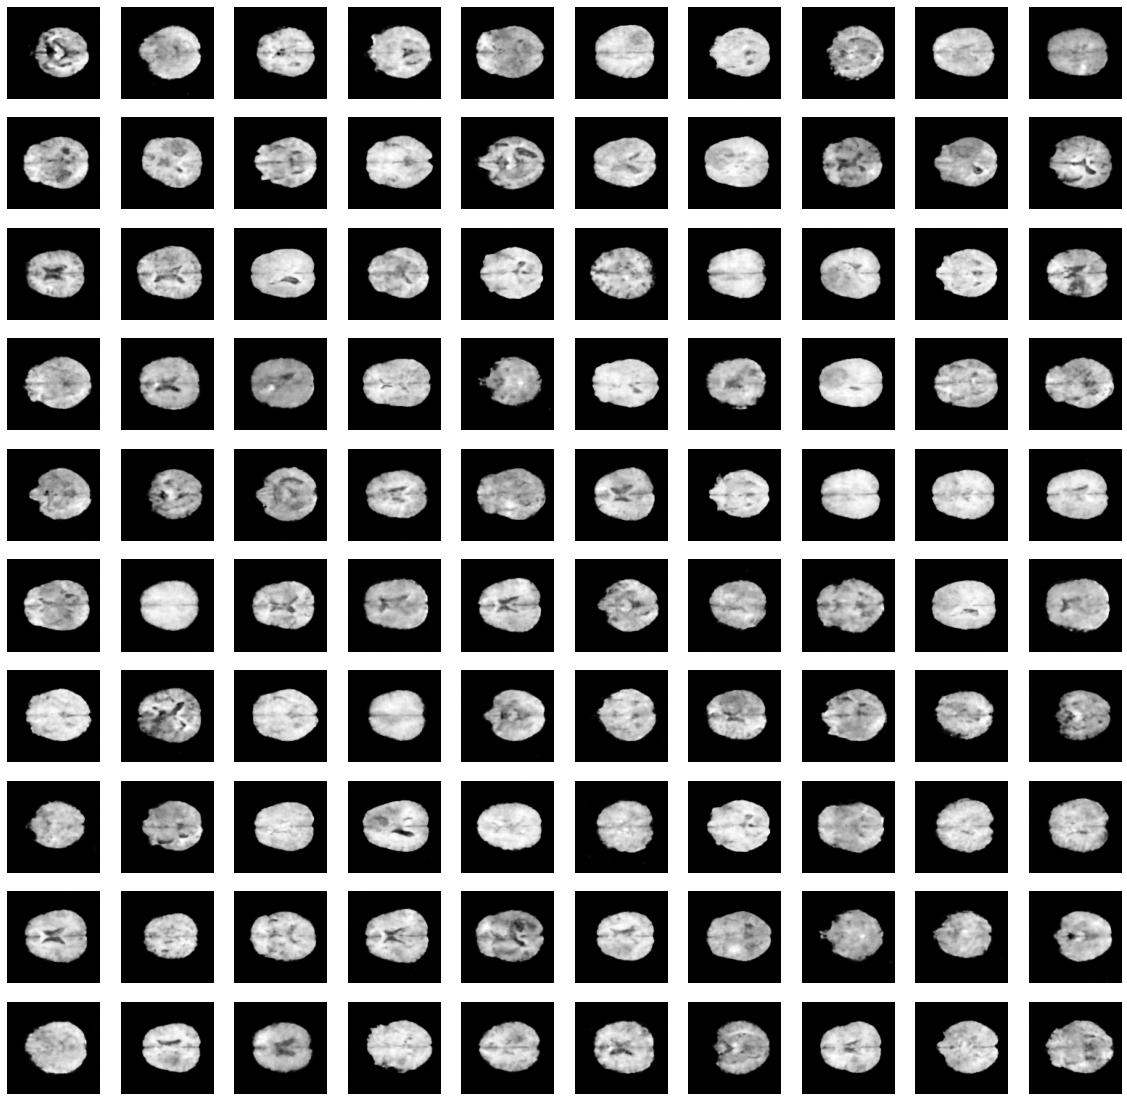

In [34]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, *IMG_SIZE)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

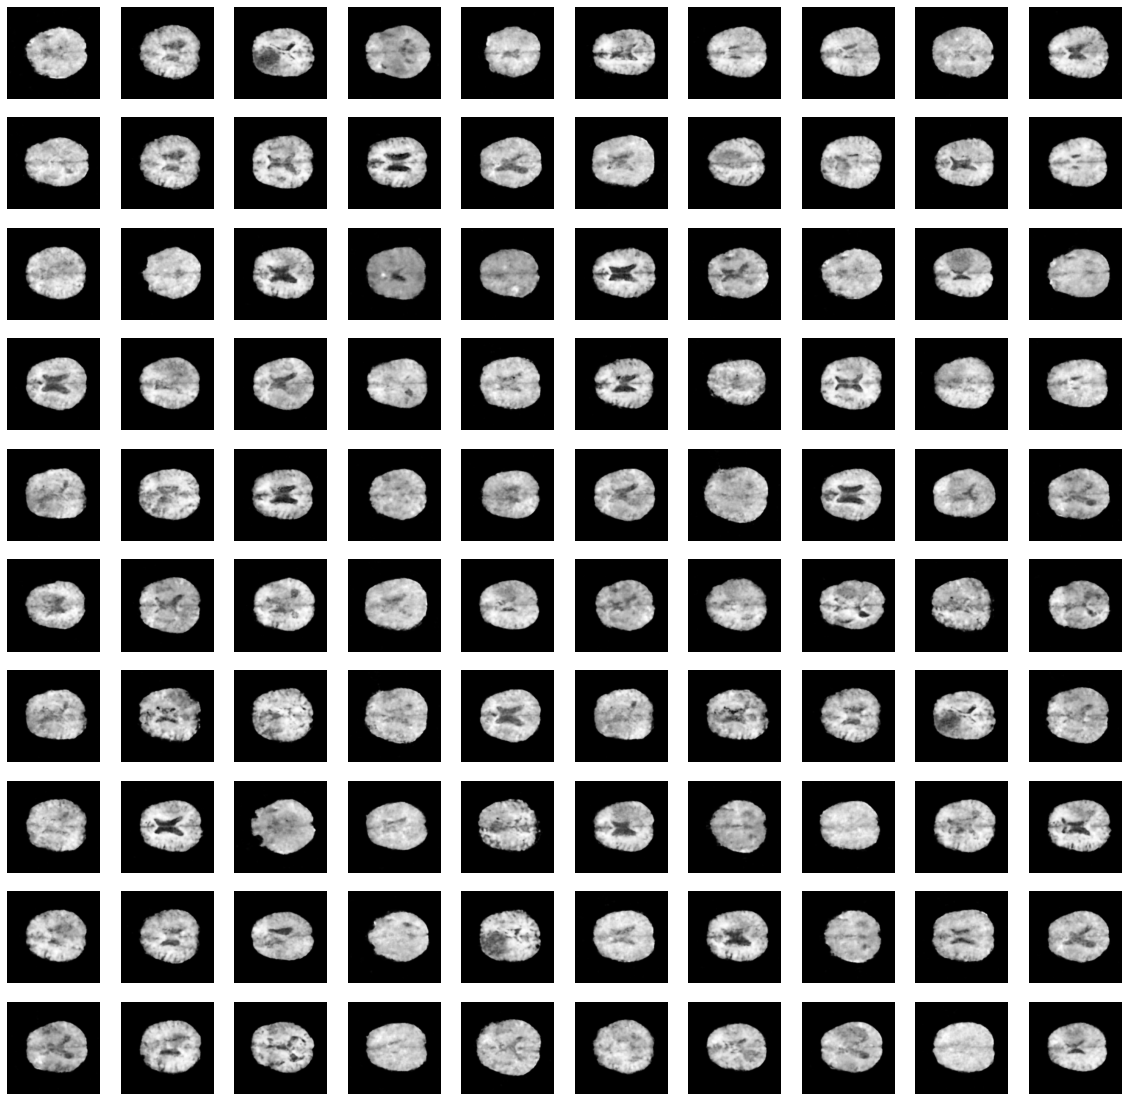

In [26]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, *IMG_SIZE)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

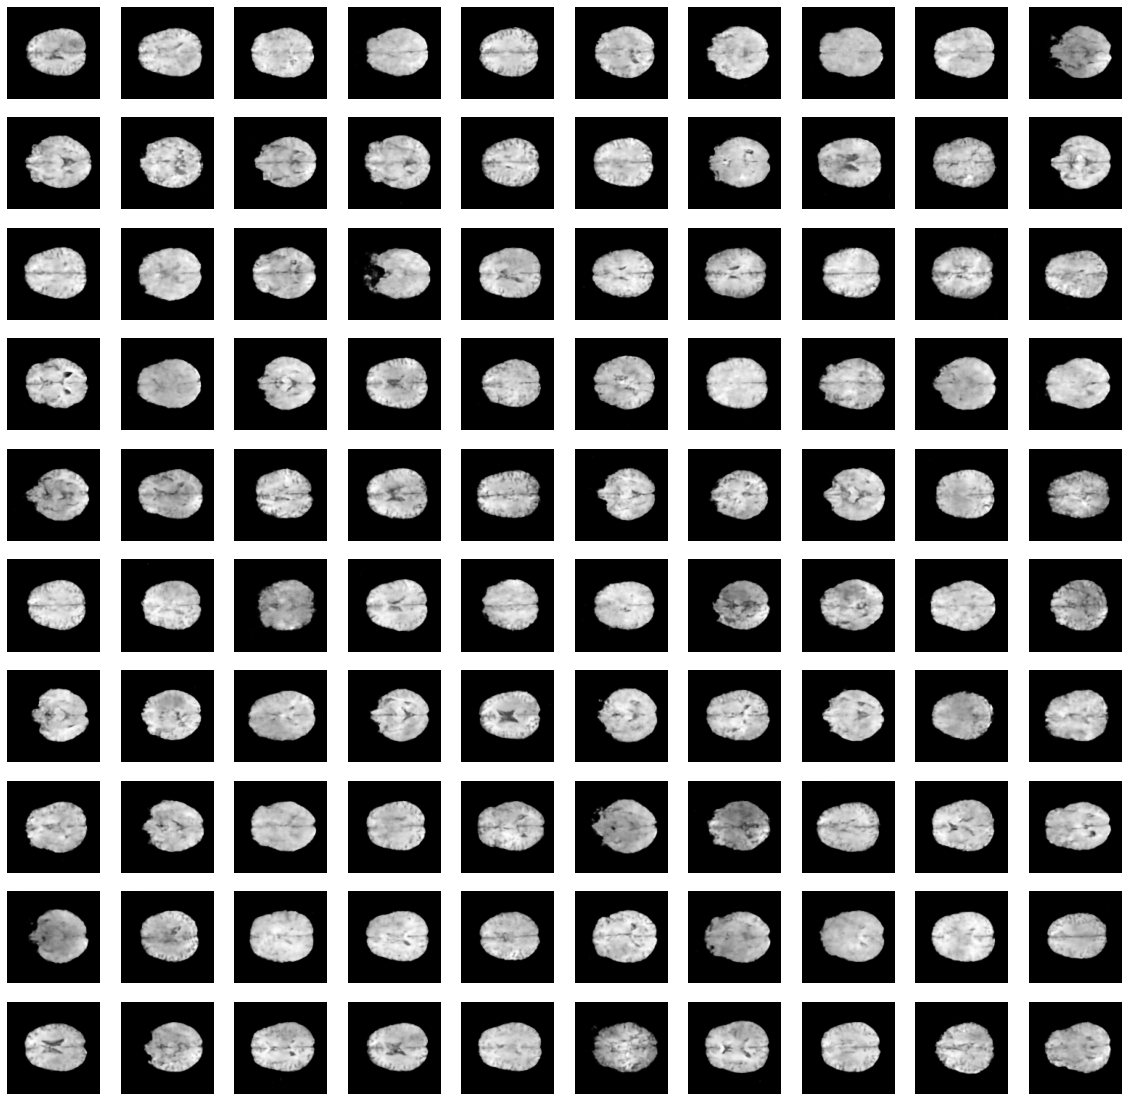

In [13]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, 128, 128)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

In [33]:
mode_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'dt': model.dt,
    'latent_dim': model.latent_dim,
    'hidden_channels': model.hidden_channels
}

torch.save(mode_checkpoint, os.path.join(WEIGHTS_DIR, 'rvae_{}_{}_{}_{}.pth'.format(IMG_SIZE[0], LATENT_DIM, model.dt, EPOCHS)))
print('saved')

saved


## Reconstruction

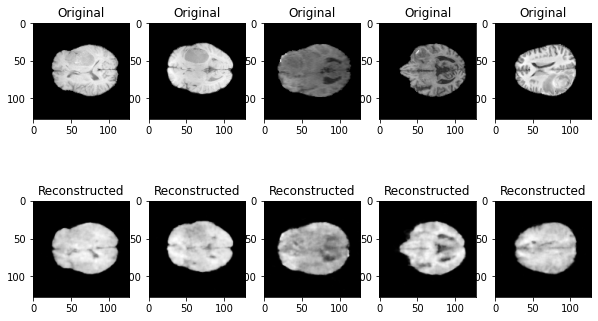

In [40]:
sample = next(iter(train_loader))[0][:5].to(device, dtype=torch.float)
recon = (model(sample)[0].detach().cpu() * 255).type(torch.uint8)

fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for i in range(5):
    ax[0, i].imshow(sample[i, 0].cpu(), cmap='gray')
    ax[0, i].set_title('Original')
    ax[1, i].imshow(recon[i, 0].cpu(), cmap='gray')
    ax[1, i].set_title('Reconstructed')

plt.show()

In [ ]:
verbose = True

# model
model = RHVAE((1, 240, 240), latent_dim=LATENT_DIM, n_lf=4, eps_lf=0.001, beta_zero=0.3, device=device,
                metric_fc=512, temperature=0.8, regularization=0.01, bilinear=False)
model.to(device)

# loss function
criterion = model.loss_function

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# data loader
train_loader = torch.utils.data.DataLoader(BraTSDataset(flair, t1), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# scheduler
scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []

for epoch in range(10000):
    for phase in ['train']:#, 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (flair, t1) in enumerate(dataloader):
            flair, t1 = flair.to(device, dtype=torch.float32), t1.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                recon_x, z, z0, rho, eps0, gamma, mu, log_var, G_inv, G_log_det = model.forward(flair)
                loss = model.loss_function(recon_x, t1, z0, z, rho, eps0, gamma, mu, log_var, G_inv, G_log_det)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            running_loss += loss.item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description('Epoch: {:5}/{} - Phase: {:6} - Loss: {:.4f}'.format(
                        epoch + 1, 10000, phase, running_loss / (i + 1)
                    ))

        if phase == 'train':
            model.update_metric()

        epoch_loss = running_loss / dataloader.__len__()
        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            test_loss_history.append(epoch_loss)

        if verbose: progress.close()
        del progress

        if verbose and epoch % 50 == 0:
            model.eval()
            generated = (model.sample_img(n_samples=5).detach().cpu().numpy() * 255).astype(np.uint8)
            plt.figure(figsize=(10, 2))
            for i in range(5):
                plt.subplot(1, 5, i + 1)
                plt.imshow(generated[i].reshape(240, 240), cmap='gray')
                plt.axis('off')
                
            plt.suptitle('Generated images')
            plt.show()

print('Training over')

In [11]:
model = RHVAE(input_shape=(NUM_CHANNELS, *IMG_SIZE), latent_dim=LATENT_DIM, hidden_channels=[32, 64, 128, 256, 256, 512, 512],
    n_lf=4, eps_lf=0.0015, beta_zero=0.3, device=device, metric_dim=128, temperature=0.8, regularization=0.01)
model.to(device)

model.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR, 'rhvae_flair_reconstruction_2000epochs.pth')))


<All keys matched successfully>

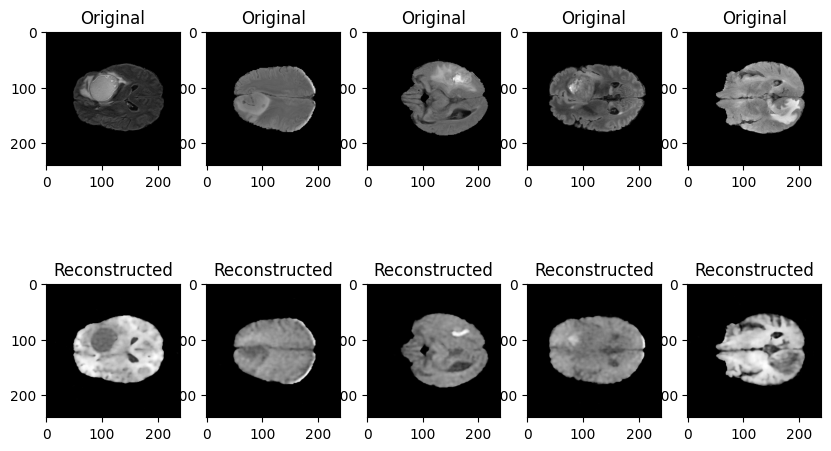

In [18]:
model.to(device)
model.train()
recon = (model.forward(flair)[0].detach().cpu() * 255).type(torch.uint8)

fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for i in range(5):
    ax[0, i].imshow(flair[i, 0].cpu(), cmap='gray')
    ax[0, i].set_title('Original')
    ax[1, i].imshow(recon[i, 0].cpu(), cmap='gray')
    ax[1, i].set_title('Reconstructed')

plt.show()